In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import log10, floor, ceil
import re
from typing import List, Dict

import warnings

warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 18})

/home/adam/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/adam/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [436]:
def splitIsotope(isotope):
    parts = re.findall(r"(\d+|[a-zA-Z]+)", isotope)
    return parts


PATH_TO_HIVAPS = "/home/adam/skola/phd/hivap/HIVAP-CODE/Hivap/MyHivap/results"
colors = [
    "black",
    "red",
    "mediumseagreen",
    "blue",
    "goldenrod",
    "fuchsia",
    "turquoise",
    "darkorange",
    "blueviolet",
    "darkgrey",
    "firebrick",
    "darkkhaki",
]

markers = ['o', 'v', '^', 's', '*', 'D', 'X', 'p', 'P', 'h', '<', '>']


In [437]:
class ExpData:
    def __init__(self, E_lab: List[float], cs_data: Dict[str, List[float]], error_data: Dict[str, List[List[float]]] = {}):
        self.E_lab = E_lab
        
        self.__checkIsotopesInData(cs_data, error_data)
        self.__checkCSDataLength(cs_data)
        self.__checkErrorDataLength(error_data)
        self.cs_data = cs_data
        self.error_data = error_data
        
    def __checkCSDataLength(self, data):
        # check that there are CS data for all listed E_lab energies
        for isotope in list(data.keys()):
            if len(self.E_lab) != len(data[isotope]):
                raise ValueError(
                    f"Non-matching length between E_lab and CS data in {isotope}"
                )
    
    def __checkErrorDataLength(self, data):
        # check that there are error data for all listed E_lab energies and if there are assymetric errors, check their dimension as well
        for isotope in list(data.keys()):
            if data[isotope]:
                if len(self.E_lab) != len(data[isotope][0]):
                    raise ValueError(
                        f"Non-matching length between E_lab and low-error data in {isotope}"
                    )
                    
                if len(data[isotope]) == 2 and len(data[isotope][0]) != len(data[isotope][1]):
                    raise ValueError(
                        f"Non-matching length between high- and low-error data in {isotope}"
                    )

    def __checkIsotopesInData(self, cs_data, error_data):
        # check that isotopes that have errors are also in the CS data
        evap_residues = set(cs_data.keys())
        error_data_isotopes = set(error_data.keys())
        if not error_data_isotopes.issubset(evap_residues):
            raise ValueError('Non-matching isotopes in error data and in CS data')

    def getEvapChannelExpData(self, evap_channel):
        exp_data = []
        if evap_channel not in self.cs_data.keys():
            raise ValueError(
                f"Evaporation channel {evap_channel} is not in the entered exp. data"
            )
        
        for index, _ in enumerate(self.E_lab):
            if evap_channel not in self.error_data.keys():
            # if not self.error_data[evap_channel]:                
                exp_data.append([self.E_lab[index], self.cs_data[evap_channel][index], np.nan, np.nan])
            elif len(self.error_data[evap_channel]) == 1:
                exp_data.append([self.E_lab[index], self.cs_data[evap_channel][index], self.error_data[evap_channel][0][index], self.error_data[evap_channel][0][index]])
            elif len(self.error_data[evap_channel]) == 2:
                exp_data.append([self.E_lab[index], self.cs_data[evap_channel][index], self.error_data[evap_channel][0][index], self.error_data[evap_channel][1][index]])
                                
        return exp_data
    
    def getAllExpData(self):
        exp_data = {}
        
        for isotope in self.cs_data:
            exp_data[isotope] = self.getEvapChannelExpData(isotope)
            
        return exp_data
        
    
    def getExpEvapResidues(self):
        return list(self.cs_data.keys())

    def getMinCS(self):
        minimum = float('inf')

        for isotope in self.cs_data.keys():
            if minimum > min(self.cs_data[isotope]):
                minimum = min(self.cs_data[isotope])
        return minimum
    
    def getMaxCS(self):
        maximum = 0

        for isotope in self.cs_data.keys():
            if maximum < max(self.cs_data[isotope]):
                maximum = max(self.cs_data[isotope])
        return maximum
    
    def getMaxE_lab(self):
        return max(self.E_lab)
    
    def getMinE_lab(self):
        return min(self.E_lab)

    def scaleExpData(self, unit):
        if unit not in ['mb', 'ub', 'nb']:
            raise ValueError('Invalid cross section unit')
        scale = 1
        
        if unit == "mb":
            scale = 1
        elif unit == "ub":
            scale = 1e3
        elif unit == "nb":
            scale = 1e6

        for isotope in self.cs_data.keys():
            self.cs_data[isotope] = [scale*i for i in self.cs_data[isotope]]
            try:
                self.error_data[isotope][0] = [scale * i for i in self.error_data[isotope][0]]
                self.error_data[isotope][1] = [scale * i for i in self.error_data[isotope][1]]
            except:
                pass



In [438]:
class Reaction:
    def __init__(
        self,
        projectile,
        target,
        cn,
        barfac,
        sigr,
        unit="mb",
        evap_channel="xn",
        bf_diff=0.00,
        channels_to_show=[],
        lowYRange=0,
        highYRange=0,
        lowXRange=0,
        highXRange=0,
        exp_data: ExpData = None,
        plot_exp_data=True
    ):
        self.projectile = projectile
        self.target = target
        self.cn = cn
        self.barfac = barfac
        if unit not in ['mb', 'ub', 'nb']:
            raise ValueError('Invalid cross section unit')
        self.unit = unit
        self.evap_channel = evap_channel
        self.sigr = sigr
        self.bf_diff = bf_diff
        self.data_ifus0, self.data_ifus10 = None, None
        (
            self.data_ifus0_bf_low,
            self.data_ifus0_bf_high,
            self.data_ifus10_bf_low,
            self.data_ifus10_bf_high,
        ) = (None, None, None, None)
        self.channels_to_show = channels_to_show
        self.lowYRange = lowYRange
        self.highYRange = highYRange
        self.lowXRange = lowXRange
        self.highXRange = highXRange
        if exp_data:
            self.exp_data = exp_data
            self.__processExpData()
        self.__getData()
        self.plot_exp_data = plot_exp_data

        if (
            not channels_to_show
        ):  # and (self.data_ifus0['isotope'].unique() == self.data_ifus10['isotope'].unique()).all():
            self.channels_to_show = self.data_ifus0["isotope"].unique()
        else:
            # add to self.channels_to_show only those that are in the data
            self.channels_to_show = []
            for channel in channels_to_show:
                if np.any(self.data_ifus0["isotope"].unique() == channel):
                    self.channels_to_show.append(channel)

        if lowYRange == 0:
            self.lowYRange = self.__lowYRange()

        if highYRange == 0:
            self.highYRange = self.__highYRange()

        if lowXRange == 0:
            self.lowXRange = self.__lowXRange()

        if highXRange == 0:
            self.highXRange = self.__highXRange()

        if self.bf_diff > 0:
            self.__getBfDiffData()

    def isotopeA(self, isotope):
        return int(splitIsotope(isotope)[0]) 

    def isotopeElement(self, isotope):
        return splitIsotope(isotope)[1]
    
    def getAllIsotopes(self):
        # first check if IFUS0 and IFUS10 have the same isotopes, then return all of them in a list
        if (self.data_ifus0['isotope'].unique() == self.data_ifus10['isotope'].unique()).all():
            return self.data_ifus0['isotope'].unique()
        else:
            raise ValueError('IFUS0 and IFUS10 do not contain the same isotopes')
        
        

    def __getData(self):
        # get data into variable
        try:
            self.data_ifus0 = pd.read_csv(
                PATH_TO_HIVAPS
                + "/"
                + self.cn.lower()
                + "/data/"
                + self.projectile
                + "_"
                + self.target
                + "_"
                + self.cn
                + "_"
                + self.evap_channel
                + "_"
                + "IFUS0"
                + "_barfac"
                + f"{self.barfac:.2f}"
                + "_sigr"
                + str(self.sigr)
                + ".dat",
                sep="\t",
            )

            self.data_ifus10 = pd.read_csv(
                PATH_TO_HIVAPS
                + "/"
                + self.cn.lower()
                + "/data/"
                + self.projectile
                + "_"
                + self.target
                + "_"
                + self.cn
                + "_"
                + self.evap_channel
                + "_"
                + "IFUS10"
                + "_barfac"
                + f"{self.barfac:.2f}"
                + "_sigr"
                + str(self.sigr)
                + ".dat",
                sep="\t",
            )

            self.data_ifus0 = self.data_ifus0.melt(
                id_vars=["E_lab", "E*/MeV"], var_name="isotope", value_name="CS"
            )
            self.data_ifus10 = self.data_ifus10.melt(
                id_vars=["E_lab", "E*/MeV"], var_name="isotope", value_name="CS"
            )

            self.__scaleData(self.data_ifus0)
            self.__scaleData(self.data_ifus10)

        except:
            print("No data found")
            self.data_ifus0, self.data_ifus10 = None, None

    def __getBfDiffData(self):
        # get data into variable
        try:
            self.data_ifus0_bf_low = pd.read_csv(
                PATH_TO_HIVAPS
                + "/"
                + self.cn.lower()
                + "/data/"
                + self.projectile
                + "_"
                + self.target
                + "_"
                + self.cn
                + "_"
                + self.evap_channel
                + "_"
                + "IFUS0"
                + "_barfac"
                + f"{self.barfac-self.bf_diff:.2f}"
                + "_sigr"
                + str(self.sigr)
                + ".dat",
                sep="\t",
            )

            self.data_ifus0_bf_high = pd.read_csv(
                PATH_TO_HIVAPS
                + "/"
                + self.cn.lower()
                + "/data/"
                + self.projectile
                + "_"
                + self.target
                + "_"
                + self.cn
                + "_"
                + self.evap_channel
                + "_"
                + "IFUS0"
                + "_barfac"
                + f"{self.barfac+self.bf_diff:.2f}"
                + "_sigr"
                + str(self.sigr)
                + ".dat",
                sep="\t",
            )

            self.data_ifus10_bf_low = pd.read_csv(
                PATH_TO_HIVAPS
                + "/"
                + self.cn.lower()
                + "/data/"
                + self.projectile
                + "_"
                + self.target
                + "_"
                + self.cn
                + "_"
                + self.evap_channel
                + "_"
                + "IFUS10"
                + "_barfac"
                + f"{self.barfac-self.bf_diff:.2f}"
                + "_sigr"
                + str(self.sigr)
                + ".dat",
                sep="\t",
            )

            self.data_ifus10_bf_high = pd.read_csv(
                PATH_TO_HIVAPS
                + "/"
                + self.cn.lower()
                + "/data/"
                + self.projectile
                + "_"
                + self.target
                + "_"
                + self.cn
                + "_"
                + self.evap_channel
                + "_"
                + "IFUS10"
                + "_barfac"
                + f"{self.barfac+self.bf_diff:.2f}"
                + "_sigr"
                + str(self.sigr)
                + ".dat",
                sep="\t",
            )

            self.data_ifus0_bf_low = self.data_ifus0_bf_low.melt(
                id_vars=["E_lab", "E*/MeV"], var_name="isotope", value_name="CS"
            )
            self.data_ifus0_bf_high = self.data_ifus0_bf_high.melt(
                id_vars=["E_lab", "E*/MeV"], var_name="isotope", value_name="CS"
            )

            self.data_ifus10_bf_low = self.data_ifus10_bf_low.melt(
                id_vars=["E_lab", "E*/MeV"], var_name="isotope", value_name="CS"
            )
            self.data_ifus10_bf_high = self.data_ifus10_bf_high.melt(
                id_vars=["E_lab", "E*/MeV"], var_name="isotope", value_name="CS"
            )

            self.__scaleData(self.data_ifus0_bf_low)
            self.__scaleData(self.data_ifus0_bf_high)
            self.__scaleData(self.data_ifus10_bf_low)
            self.__scaleData(self.data_ifus10_bf_high)

        except:
            print("No data found for difference plotting")
            (
                self.data_ifus0_bf_low,
                self.data_ifus0_bf_high,
                self.data_ifus10_bf_low,
                self.data_ifus10_bf_high,
            ) = (None, None, None, None)

    def __scaleData(self, dataframe):
        scale = 1
        if self.unit == "mb":
            scale = 1
        elif self.unit == "ub":
            scale = 1e3
        elif self.unit == "nb":
            scale = 1e6

        dataframe["CS"] = dataframe["CS"].multiply(scale)

    def __lowYRange(self):
        # find maximum of the 'smallest' excit. function (IFUS10) to be plotted and then set the minimum to 1 order lower, or min of exp data if it is lower
        lowest_max = float("inf")
        for channel in self.channels_to_show:
            if (
                self.data_ifus10[self.data_ifus10["isotope"] == channel]["CS"].max() > 0
                and self.data_ifus10[self.data_ifus10["isotope"] == channel]["CS"].max()
                < lowest_max
            ):
                lowest_max = self.data_ifus10[self.data_ifus10["isotope"] == channel][
                    "CS"
                ].max()
        
        try:
            return self.roundMinYRange(self.exp_data.getMinCS() if self.exp_data.getMaxCS() < lowest_max else lowest_max)
        except:
            return self.roundMinYRange(lowest_max)
        
    def __highYRange(self):
        # find maximum of the 'largest' excit. function (IFUS10) to be plotted and set the maximum to 1 order higher, or max of exp data if it is higher
        highest_max = 0
        for channel in self.channels_to_show:
            if (
                self.data_ifus10[self.data_ifus10["isotope"] == channel]["CS"].max() > 0
                and self.data_ifus10[self.data_ifus10["isotope"] == channel]["CS"].max()
                > highest_max
            ):
                highest_max = self.data_ifus10[self.data_ifus10["isotope"] == channel][
                    "CS"
                ].max()
                
        try:
            return self.roundMaxYRange(self.exp_data.getMaxCS() if self.exp_data.getMaxCS() > highest_max else highest_max)
        except:
            return self.roundMaxYRange(highest_max)
                
    
    def roundMinYRange(self, value):
        return 10 ** round(log10(value)) / 10

    def roundMaxYRange(self, value):
        return 10 ** round(log10(value)) * 10
    
    def __lowXRange(self):
        # get minimum energy for which the CS value is larger than lowYRange or minimum of  E_lab of exp data if it is lower
        try:
            return min(self.roundMinXRange(self.data_ifus10[self.data_ifus10["isotope"].isin(self.channels_to_show)][self.data_ifus10["CS"] > self.lowYRange]["E_lab"].min()), self.exp_data.getMinE_lab())
        except:
            return self.roundMinXRange(self.data_ifus10[self.data_ifus10["isotope"].isin(self.channels_to_show)][self.data_ifus10["CS"] > self.lowYRange]["E_lab"].min())

    def __highXRange(self):
        # get maximum energy for which the CS value is larger than lowYRange or minimum of  E_lab of exp data if it is lower
        try:
            return max(self.roundMaxXRange(self.data_ifus10[self.data_ifus10["isotope"].isin(self.channels_to_show)][self.data_ifus10["CS"] > self.lowYRange]["E_lab"].max()), self.exp_data.getMaxE_lab())
        except:
            return self.roundMaxXRange(self.data_ifus10[self.data_ifus10["isotope"].isin(self.channels_to_show)][self.data_ifus10["CS"] > self.lowYRange]["E_lab"].max())
        
    def roundMinXRange(self, value): 
        return floor(value / 10) * 10
    
    def roundMaxXRange(self, value): 
        return ceil(value / 10) * 10
    
    def plot(self, plot_diff=True, alpha_value=0.15, show_title=False):
        fig, ax = plt.subplots(figsize=(12, 6))

        sns.lineplot(
            x="E_lab",
            y="CS",
            hue="isotope",
            data=self.data_ifus10[
                self.data_ifus10["isotope"].isin(self.channels_to_show)
            ],
            palette=colors,
        )
        sns.lineplot(
            x="E_lab",
            y="CS",
            hue="isotope",
            data=self.data_ifus0[
                self.data_ifus0["isotope"].isin(self.channels_to_show)
            ],
            legend=None,
            linestyle="--",
            palette=colors,
        )
        for text in plt.legend(loc="upper right").get_texts():
            label = text.get_text()
            text.set_text(
                "$^{" + str(self.isotopeA(label)) + "}$" + self.isotopeElement(label)
            )

        plt.semilogy()
        plt.ylim(self.lowYRange, self.highYRange)
        plt.xlim(self.lowXRange, self.highXRange)
        if self.unit == "ub":
            plt.ylabel("$\sigma$ [$\mu$b]", fontsize=20)
        else:
            plt.ylabel(f"$\sigma$ [{self.unit}]", fontsize=20)

        plt.xlabel("$E_{proj}$ [MeV]", fontsize=20)

        if show_title:
            plt.title(
                r"$^{"
                + str(self.isotopeA(self.projectile))
                + "}$"
                + self.isotopeElement(self.projectile)
                + r" + $^{"
                + str(self.isotopeA(self.target))
                + "}$"
                + self.isotopeElement(self.target)
                + r" $\rightarrow$ $^{"
                + str(self.isotopeA(self.cn))
                + "}$"
                + self.isotopeElement(self.cn)
                + r"$^*$, BF = "
                + str(self.barfac)
                + str("" if self.bf_diff == 0 else (r" $\pm$ " + str(self.bf_diff)))
            )

        if plot_diff and self.bf_diff > 0:
            self.__plotBfDiff(alpha_value)
        
        if self.plot_exp_data:
            self.__plotExpData()
            
    def __plotBfDiff(self, alpha_value):
        for index, channel in enumerate(self.channels_to_show):
            plt.fill_between(
                self.data_ifus0[self.data_ifus0["isotope"] == channel]["E_lab"],
                self.data_ifus0[self.data_ifus0["isotope"] == channel]["CS"],
                self.data_ifus0_bf_low[self.data_ifus0_bf_low["isotope"] == channel][
                    "CS"
                ],
                color=colors[index],
                alpha=alpha_value,
            )

            plt.fill_between(
                self.data_ifus0[self.data_ifus0["isotope"] == channel]["E_lab"],
                self.data_ifus0[self.data_ifus0["isotope"] == channel]["CS"],
                self.data_ifus0_bf_high[self.data_ifus0_bf_high["isotope"] == channel][
                    "CS"
                ],
                color=colors[index],
                alpha=alpha_value,
            )

            plt.fill_between(
                self.data_ifus10[self.data_ifus10["isotope"] == channel]["E_lab"],
                self.data_ifus10[self.data_ifus10["isotope"] == channel]["CS"],
                self.data_ifus10_bf_low[self.data_ifus10_bf_low["isotope"] == channel][
                    "CS"
                ],
                color=colors[index],
                alpha=alpha_value,
            )

            plt.fill_between(
                self.data_ifus10[self.data_ifus10["isotope"] == channel]["E_lab"],
                self.data_ifus10[self.data_ifus10["isotope"] == channel]["CS"],
                self.data_ifus10_bf_high[
                    self.data_ifus10_bf_high["isotope"] == channel
                ]["CS"],
                color=colors[index],
                alpha=alpha_value,
            )

    def saveFig(self, note="", extension="pdf"):
        extension_types = ["pdf", "svg", "png"]
        if extension not in extension_types:
            raise ValueError(
                "Invalid extension type, please choose one from: %s" % extension_types
            )

        plt.savefig(
            "figs/"
            + self.projectile
            + "_"
            + self.target
            + "_"
            + self.cn
            + "_"
            + self.evap_channel
            + "_barfac"
            + f"{self.barfac:.2f}"
            + "_sigr"
            + str(self.sigr)
            + str("" if len(note) == 0 else "_")
            + note
            + "."
            + extension,
            bbox_inches="tight",
        )

    def __processExpData(self):
        self.__checkIsotopesInData()
        self.exp_data.scaleExpData(self.unit)

    def __checkIsotopesInData(self):
        exp_data_isotopes = set(self.exp_data.cs_data.keys())
        isotopes_to_show = set(self.channels_to_show)
        
        if not exp_data_isotopes.issubset(isotopes_to_show):
            raise ValueError('Experimental data contain isotopes which are not in the selected HIVAPs')
            
    def __plotExpData(self):
        try:
            for isotope in self.exp_data.getExpEvapResidues():
                print(isotope)
                for exp_data in self.exp_data.getEvapChannelExpData(isotope):
                    print(exp_data[2])
                    (_, caps, _) = plt.errorbar(exp_data[0], exp_data[1], yerr=[[exp_data[2]], [exp_data[3]]], marker=markers[self.channels_to_show.index(isotope)], color=colors[self.channels_to_show.index(isotope)], ls='none', markersize=7, capsize=5)
                    for cap in caps:
                        cap.set_markeredgewidth(1)
        except:
            print("No exp data found")



193At
0.1
5


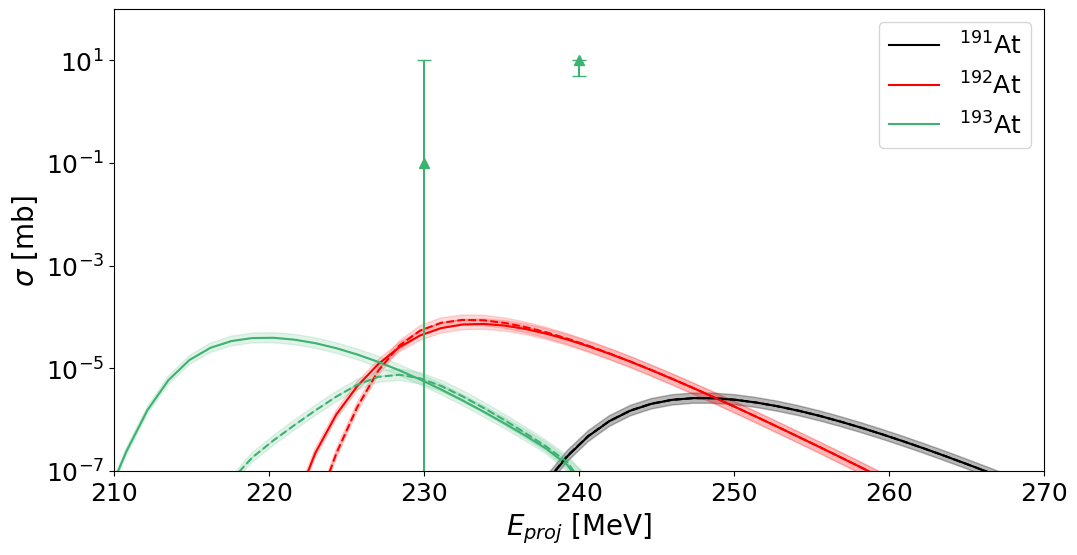

In [434]:
# reaction = Reaction('51V', '144Sm', '195At', 0.64, 2.5, bf_diff=0.01, channels_to_show=['191At', '192At', '193At'], unit='ub', exp_data=ExpData([230, 240], {'193At': [1e-4, 5e-5]}, error_data={'193At': [[5e-5, 1e-3], [1e-5, 1e-5]]}))

reaction = Reaction('51V', '144Sm', '195At', 0.64, 2.5, bf_diff=0.01, channels_to_show=['191At', '192At', '193At'], unit='mb', exp_data=ExpData([230, 240], {'193At': [0.1, 10]}, error_data={'193At': [[0.1, 5], [10, 0.01]]}))


reaction1 = Reaction('51V', '144Sm', '195At', 0.64, 2.5, bf_diff=0.01, channels_to_show=['191At', '192At', '193At'], unit='ub')

reaction.plot()

In [439]:
reactions = [
    Reaction('90Zr', '103Rh', '193At', 0.44, 3.0, bf_diff=0.01, channels_to_show=['190At'], unit='nb'),
    Reaction('51V', '144Sm', '195At', 0.64, 2.5, bf_diff=0.01, channels_to_show=['191At', '192At', '193At'], unit='ub'),
    Reaction('54Fe', '141Pr', '195At', 0.64, 2.5, bf_diff=0.01, channels_to_show=['191At', '192At', '193At'], unit='ub'),
    Reaction('56Fe', '141Pr', '197At', 0.66, 2.5, bf_diff=0.01, channels_to_show=['193At', '194At', '195At'], unit='ub'),
    Reaction('51V', '147Sm', '198At', 0.67, 2.8, bf_diff=0.01, channels_to_show=['194At', '195At', '196At'], unit='ub'),
    Reaction('40Ca', '159Tb', '199At', 0.76, 3.2, bf_diff=0.01, channels_to_show=['194Po', '195Po', '196Po'], unit='ub', evap_channel='pxn'),
    Reaction('45Sc', '156Gd', '201At', 0.65, 3.2, bf_diff=0.01, channels_to_show=['197At', '198At'], unit='ub'),
    Reaction('45Sc', '157Gd', '202At', 0.70, 3.2, bf_diff=0.01, channels_to_show=['197At', '198At', '199At'], unit='ub'),
    Reaction('45Sc', '158Gd', '203At', 0.71, 3.2, bf_diff=0.01, channels_to_show=['198At', '199At', '200At'], unit='ub'),
    Reaction('44Ca', '159Tb', '203At', 0.69, 3.2, bf_diff=0.01, channels_to_show=['198At', '199At', '200At'], unit='ub'),
    Reaction('40Ar', '165Ho', '205At', 0.79, 3.3, bf_diff=0.01, channels_to_show=['196At', '197At', '198At', '199At', '200At', '201At', '202At'], unit='mb'),
    Reaction('24Mg', '181Ta', '205At', 0.78, 3.2, bf_diff=0.01, channels_to_show=['197At', '198At', '199At', '200At'], unit='mb'),
    Reaction('26Mg', '181Ta', '207At', 0.81, 3.2, bf_diff=0.01, channels_to_show=['200At', '201At', '202At', '203At'], unit='mb'),
    Reaction('48Ca', '159Tb', '207At', 0.82, 3.2, bf_diff=0.01, channels_to_show=['201At', '202At', '203At', '204At'], unit='mb'),
]

In [ ]:
for reaction in reactions:
    reaction.plot(show_title=True)
    reaction.saveFig()

No exp data found
No exp data found
No exp data found
No exp data found
No exp data found
No exp data found
No exp data found
No exp data found
No exp data found
No exp data found
No exp data found
No exp data found
